Calculates linear trend of an xarray object

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import xarray as xr

Define arrays

In [11]:
nt = 37
nx = 3
ny = 4
slope = xr.DataArray(np.random.randn(nx*ny).reshape(ny,nx), 
                     coords=[np.arange(ny),np.arange(nx)],
                     dims=['Y','X'])
time = xr.DataArray(np.arange(nt), coords=[np.arange(nt)], dims=['time'])
y = slope*time + np.random.randn(nx*ny*nt).reshape(ny,nx,nt)
y

<xarray.DataArray (Y: 4, X: 3, time: 37)>
array([[[ -3.108821e-01,   2.046072e-01, ...,  -1.036731e+01,  -1.003328e+01],
        [ -2.488116e+00,   1.035832e+00, ...,  -1.073412e+01,  -1.097361e+01],
        [  1.024798e+00,   6.554364e-01, ...,   4.403282e+01,   4.483783e+01]],

       [[  6.638248e-02,  -8.652327e-01, ...,  -1.678830e+01,  -1.862735e+01],
        [ -3.029171e-02,   2.506089e-01, ...,   3.804189e+01,   3.884661e+01],
        [ -4.822665e-01,  -1.255391e+00, ...,  -4.349730e+01,  -4.842515e+01]],

       [[  9.867969e-01,  -3.242344e-01, ...,   3.082338e+01,   3.289411e+01],
        [  1.385422e+00,   9.327507e-01, ...,   8.813835e+00,   9.457467e+00],
        [  1.310397e+00,   2.925503e+00, ...,   4.387897e+01,   4.641926e+01]],

       [[  1.017223e+00,   5.619297e-01, ...,   3.440248e+01,   3.617423e+01],
        [ -7.284515e-01,   4.826942e-01, ...,  -1.243424e+01,  -1.333979e+01],
        [ -2.383668e-01,  -5.626077e-01, ...,   4.143306e+00,   4.123282e+00]]])
Co

Define function to calculate trend

In [44]:
def _linear_trend(x):
    import scipy.stats
    b1, b0, r, p, se = scipy.stats.linregress(x.time, x)
    #return xr.DataArray(b1)
    return xr.Dataset({'b1': b1,
                       'b0': b0,
                       'r': r,
                       'p': p,
                       'se': se})

def xr_trend(da, dim='time'):
    if dim not in da.dims:
        print ('Not {:s} dimension in DataArray'.format(dim))
        return
    
    stack_dims = [d for d in da.dims if d != dim]
    dastack = da.stack(allpoints=stack_dims)
    
    trend = dastack.groupby('allpoints').apply(_linear_trend)
    
    print (trend)
    
    return trend.unstack('allpoints')

In [46]:
trend = xr_trend(y)
print trend.b1
print slope

<xarray.Dataset>
Dimensions:    (allpoints: 12)
Coordinates:
  * allpoints  (allpoints) MultiIndex
  - Y          (allpoints) int64 0 0 0 1 1 1 2 2 2 3 3 3
  - X          (allpoints) int64 0 1 2 0 1 2 0 1 2 0 1 2
Data variables:
    p          (allpoints) float64 3.369e-20 4.908e-20 2.633e-41 2.339e-30 ...
    r          (allpoints) float64 -0.9559 -0.9549 0.9973 -0.9886 0.9968 ...
    b0         (allpoints) float64 0.2402 -0.2279 0.5718 -0.2894 0.1353 ...
    b1         (allpoints) float64 -0.2781 -0.3258 1.249 -0.4681 1.098 ...
    se         (allpoints) float64 0.01445 0.01712 0.01553 0.01207 0.01487 ...
<xarray.DataArray 'b1' (Y: 4, X: 3)>
array([[-0.278051, -0.325752,  1.249013],
       [-0.468133,  1.098138, -1.293319],
       [ 0.900088,  0.220532,  1.283879],
       [ 0.978904, -0.365628,  0.143876]])
Coordinates:
  * Y        (Y) int64 0 1 2 3
  * X        (X) int64 0 1 2
<xarray.DataArray (Y: 4, X: 3)>
array([[-0.255492, -0.311051,  1.274854],
       [-0.466403,  1.105203, -1

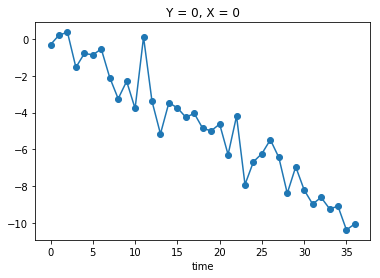

In [49]:
y[0,0,:].plot.line('-o')

## Calculate Covariance

In [62]:
# Calculate covariance
yanom = (y - y.mean())
tanom = (y.time - y.time.mean())
cov = (yanom * tanom).mean(dim='time')

<xarray.DataArray (Y: 4, X: 3)>
array([[ -31.697791,  -37.135743,  142.387537],
       [ -53.367122,  125.187711, -147.438367],
       [ 102.609982,   25.140643,  146.362232],
       [ 111.595052,  -41.681609,   16.401886]])
Coordinates:
  * Y        (Y) int32 0 1 2 3
  * X        (X) int32 0 1 2

## Calculate correlation

In [64]:
corr = cov / y.std(dim='time') / y.time.std()

## Calculate regression coeficient and constant

In [67]:
beta = corr * y.std(dim='time') / y.time.std()
alpha = y.mean(dim='time') - beta * y.time.mean()
print (beta)
print (alpha)
print (slope)

<xarray.DataArray (Y: 4, X: 3)>
array([[-0.278051, -0.325752,  1.249013],
       [-0.468133,  1.098138, -1.293319],
       [ 0.900088,  0.220532,  1.283879],
       [ 0.978904, -0.365628,  0.143876]])
Coordinates:
  * Y        (Y) int32 0 1 2 3
  * X        (X) int32 0 1 2
<xarray.DataArray (Y: 4, X: 3)>
array([[ 0.240232, -0.227878,  0.571797],
       [-0.289439,  0.135321,  0.006436],
       [ 0.068033,  0.355675,  0.418834],
       [ 0.220607, -0.18007 , -0.199858]])
Coordinates:
  * Y        (Y) int32 0 1 2 3
  * X        (X) int32 0 1 2
<xarray.DataArray (Y: 4, X: 3)>
array([[-0.255492, -0.311051,  1.274854],
       [-0.466403,  1.105203, -1.28986 ],
       [ 0.904573,  0.245681,  1.308893],
       [ 0.980732, -0.365718,  0.148478]])
Coordinates:
  * Y        (Y) int32 0 1 2 3
  * X        (X) int32 0 1 2


In [68]:
yhat = alpha + beta*y.time

In [73]:
sse = ((y - yhat)**2).sum(dim='time')
ssy = ((y - y.mean(dim='time'))**2).sum(dim='time')
r2 = 1. - sse/ssy

In [74]:
r2

<xarray.DataArray (Y: 4, X: 3)>
array([[ 0.913677,  0.911806,  0.994617],
       [ 0.977279,  0.993627,  0.995761],
       [ 0.98867 ,  0.848594,  0.99599 ],
       [ 0.991428,  0.951334,  0.700161]])
Coordinates:
  * Y        (Y) int32 0 1 2 3
  * X        (X) int32 0 1 2